In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


# Задача 2
Подведите результаты эксперимента в экселе по следующим данным: [ab_stats.csv]() Стат значимо ли отличается ARPPU в двух группах ? Какие рекомендации дадите менеджеру?

## Решение
Итоговый файл в форматах [ODS](./documents/ab_stats_ready.ods) и [XLSX](./documents/ab_stats_ready.xlsx) доступны по ссылкам. В сводной таблице были рассчитаны среднее значение по выборкам, количество визитов на сайт, стандартное отклонение, а также минимум и максимум в выборках.

По выборке A:

1. Среднее значение 6.97
2. Минимум -12.07
3. Максимум 17.73
4. Стандартное отклонение 2.02
5. Размер выборки 11835

По выборке B:

1. Среднее значение 7.05
2. Минимум -8.29
3. Максимум 22.45
4. Стандартное отклонение 3.98
5. Размер выборки 11817

Для проверки нормальности были построены частотные графики распределения:

![Частотный график выборки A](./images/pic_02_01.jpg)

Рис. 1. Частотный график выборки A

![Частотный график выборки B](./images/pic_02_02.jpg)

Рис. 2. Частотный график выборки B


Наложим гистограммы распределения.

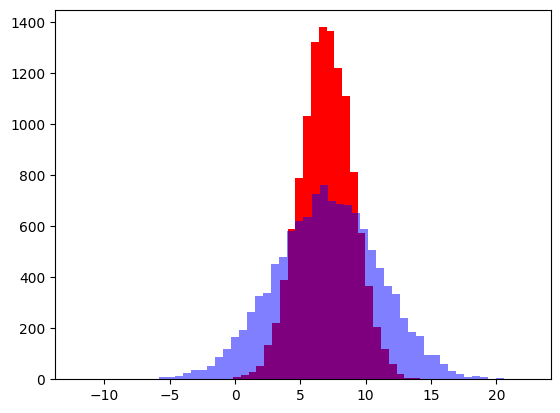

In [218]:
file_name = './documents/ab_stats.xlsx'
xl_data = pd.ExcelFile(file_name)
df = xl_data.parse('ab_stats')
df['ab_group'] = df['ab_group'].astype(str)
df['av_site visit'] = df['av_site_visit'].astype(float)
data_a = df[(df.ab_group == 'A')]['av_site_visit']
data_b = df[(df.ab_group == 'B')]['av_site_visit']
plt.hist(data_a, color='red', bins=50)
plt.hist(data_b, color='blue', bins=50, alpha=0.5)
plt.show()


Визуально выборки подчинаются нормальному закону распределения. Но выборка A имеет аномальные значения в левой части графика, и частотные графики двух выборок различаются. Проверим нормальность распределения с помощью теста Шапиро-Уилка.

In [219]:
print(f'p-value A = {round(stats.shapiro(data_a)[1], 2)}')
print(f'p-value B = {round(stats.shapiro(data_b)[1], 2)}')


p-value A = 0.0
p-value B = 0.36


По результатам теста p-value выборки B в тесте Шапиро-Уилка составляет 0.355, т. е. больше 0.05. Выборка B с вероятностью 0.95 подчиняется нормальному закону распределения. Значение p-value выборки A составляет 0.00, то есть, выборка не подчиняется нормальному распределению. Вероятно, данные по средней выручке на одного платящего пользователя для групп A и B собирались различными методами, Причем оба метода дают некорректные данные: имеются отрицательные значения, что особенно характерно для группы B.

Учитывая этот факт, определять статистическую значимость различий ARPPU не представляется возможным. Использование критерия Манна-Уитни для сравнения двух независимых групп неподчиняющихся закону нормального распределения покажет, что группы имеют статистически значиные различия (p-value = 0.02).

In [220]:
print(f'p-value = {stats.mannwhitneyu(data_a, data_b)[1]}')


p-value = 0.015552525404162418


Использование же критерия Стьюдента (T-тест для двух независимых выборок с нормальным распределение) покажет, что статистическая значимые различия между группами отсутствует (p-value = 0.06 > 0.05, $ \alpha $ = 0.95).

In [221]:
print(f'p-value = {stats.ttest_ind(data_a, data_b)[1]}')


p-value = 0.06107754367847282


Судя по графику частотного распределения, часть выборки группы A подчиняется закону нормального распределения. Если отбросить "аномальные" значения, например, все значения менее 0 и все значения более 15, то в этом случае, p-value теста Шапиро будет равна 0.21, т. е. выборка будет нормальной. Размер выборки составит 11825 значений, т. е. отброшено всего 10 измерений (менее 0.1%), это значительно меньше допустимого порога в 5%, которые могли бы повлиять на результаты тестирования.

In [222]:
data_a = df[(df.ab_group == 'A') & (df.av_site_visit > 0)
            & (df.av_site_visit < 15)]['av_site_visit']
print(
    f'p-value A = {round(stats.shapiro(data_a)[1], 2)}, n = {data_a.count()}')


p-value A = 0.21, n = 11825


Построим гистрограмму частотного распределения с учетом исправленной выборки A:

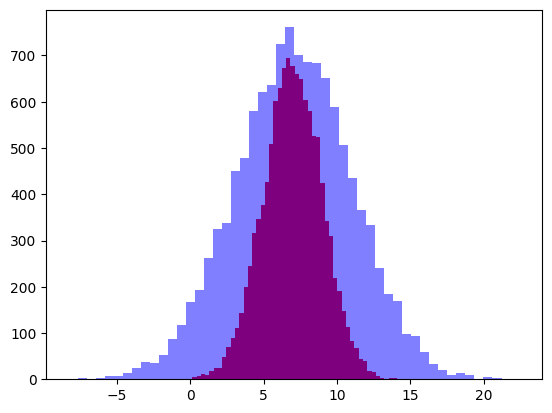

In [223]:
plt.hist(data_a, color='red', bins=50)
plt.hist(data_b, color='blue', bins=50, alpha=0.5)
plt.show()


Для двух выборок, подчиняющихся закону нормального распределения для оценки статистически значимой разницы можно применить критерий Стьюдента (T-тест).

In [224]:
print(f'p-value = {stats.ttest_ind(data_a, data_b)[1]}')


p-value = 0.07014433122959791


T-тест продемонстрировал отсутствие статистически значимой разницы между группами A и B (p-value = 0.07 > 0.05, $ \alpha $ = 0.95).

## Выводы и рекомендации

1. Между выборками A и B не обнаружены статистически значимые различия (p-value очищенных групп равно 0.07).
2. Частотный график демонстрирует разный характер распределения в группах A и B. Кроме того, в группе B фиксируется большое количество отрицательных значений метрики ARPPU, что не характерно для группы A. Если данные верны, то это может свидетельствовать об ошибках дизайна A/B-тестирования.
3. Учитывая полученные результаты, рекомендовать к использованию вариант A или B не представляется возможным.